In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import prince  # Necesario para el análisis de correspondencias

# Cargar los datos
nombre_csv = 1
data = pd.read_csv(f'Data1_procesados/{nombre_csv}.csv')

# Definir la fecha límite y filtrar el DataFrame
fecha_limite = '2024-01-07'
df_7days = data[data['Fecha'] <= fecha_limite].copy()

# Normalizar los datos para PCA (sin 'Fecha' y 'Hora')
scaler = StandardScaler()
continue_data = df_7days[['period eating', 'period other', 'period resting', 'period rumination']]
continue_data_scaled = scaler.fit_transform(continue_data)

# Aplicar PCA para análisis de actividad
pca = PCA(n_components=2)
components = pca.fit_transform(continue_data_scaled)

# Crear un DataFrame para los componentes principales
loadings = pca.components_.T
loadings_continue_data = pd.DataFrame(data=loadings, index=continue_data.columns, columns=['Principal Component 1', 'Principal Component 2'])

# Calcular los pesos y el nivel de actividad basado en PCA
pca_weights = (loadings_continue_data['Principal Component 1'] + loadings_continue_data['Principal Component 2']) / 2
activity_level = continue_data.dot(pca_weights)
# Añadir el nivel de actividad basado en PCA al DataFrame filtrado
df_7days['activity_level'] = activity_level

# Calcular y añadir el nivel de actividad (PCA) al DataFrame original `data`
data_continue = data[['period eating', 'period other', 'period resting', 'period rumination']]
data['activity_level'] = data_continue.dot(pca_weights)

# Paso adicional: Aplicar AFC en columnas de conteo
# Seleccionar solo las columnas de conteo para AFC
count_data = df_7days[['period eating_count', 'period other_count', 'period resting_count', 'period rumination_count']]

# Aplicar AFC
ca = prince.CA(n_components=2, n_iter=10)
ca = ca.fit(count_data)

# Obtener coordenadas de columnas (variables) para AFC
col_coords = ca.column_coordinates(count_data)

# Calcular los pesos de AFC para cada variable
afc_weights = (col_coords[0] + col_coords[1]) / 2
afc_weights.index = count_data.columns  # Asegurarse de que los índices coincidan con las columnas originales

# Calcular el nivel de actividad basado en AFC
activity_level_2 = count_data.dot(afc_weights)
df_7days['activity_level_2'] = activity_level_2

# Calcular y añadir el nivel de actividad (AFC) al DataFrame original `data`
data_count = data[['period eating_count', 'period other_count', 'period resting_count', 'period rumination_count']]
data['activity_level_2'] = data_count.dot(afc_weights)




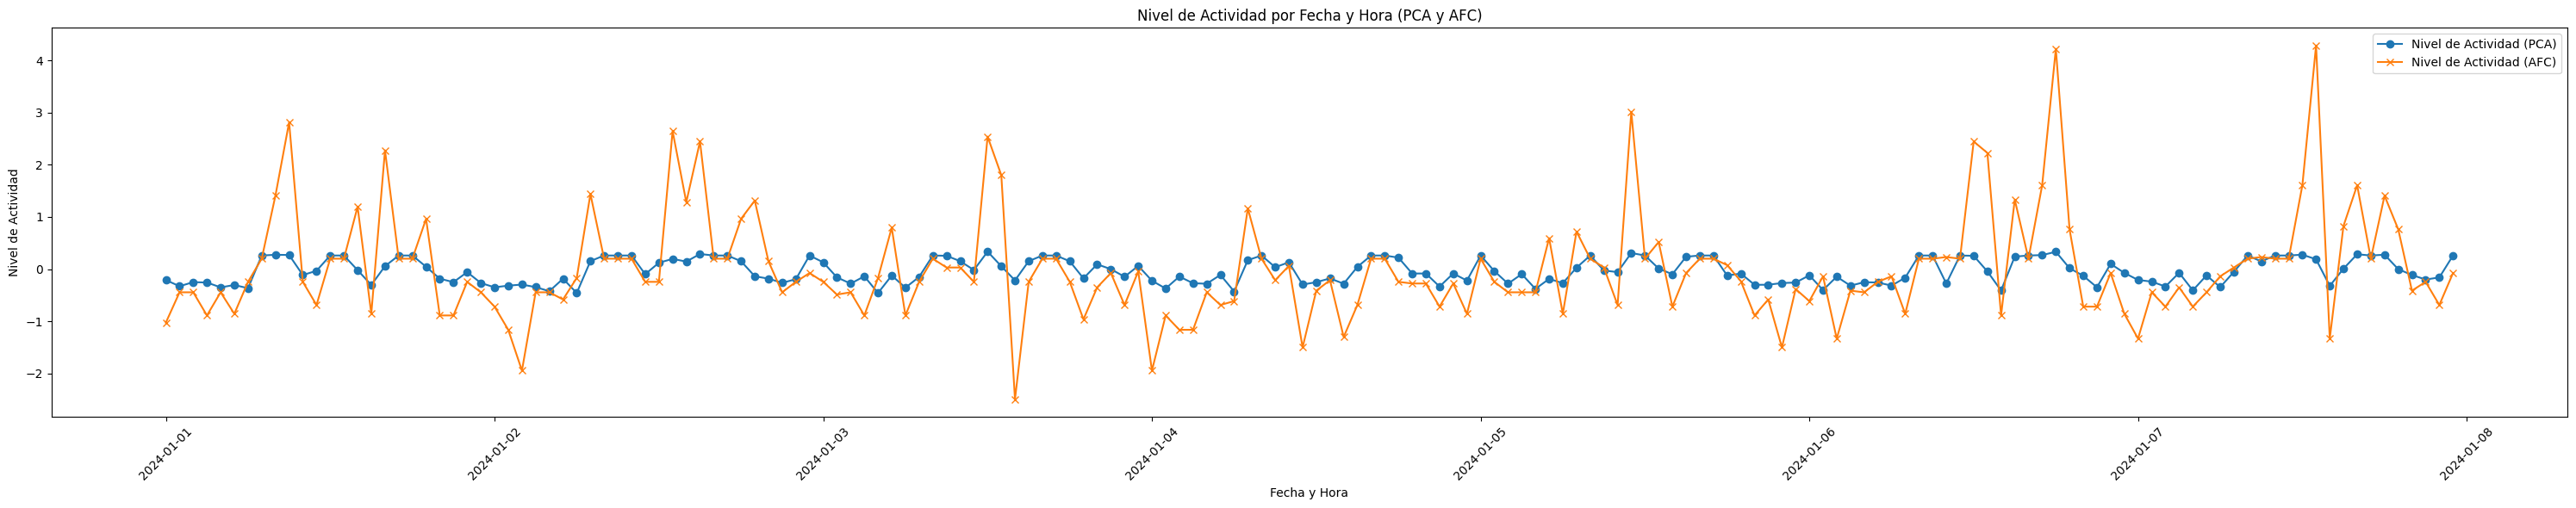

In [41]:
# Crear la columna datetime combinando 'Fecha' y 'Hora'
df_7days['FechaHora'] = df_7days.apply(lambda row: pd.Timestamp(row['Fecha']) + pd.Timedelta(hours=row['Hora']), axis=1)

# Asegurarse de que los datos estén ordenados por 'FechaHora'
df_7days.sort_values('FechaHora', inplace=True)

# Visualizar los resultados de PCA y AFC como gráficos de líneas
plt.figure(figsize=(30, 6))
plt.plot(df_7days['FechaHora'], df_7days['activity_level'], marker='o', label='Nivel de Actividad (PCA)')
plt.plot(df_7days['FechaHora'], df_7days['activity_level_2'], marker='x', label='Nivel de Actividad (AFC)')
plt.xlabel('Fecha y Hora')
plt.ylabel('Nivel de Actividad')
plt.title('Nivel de Actividad por Fecha y Hora (PCA y AFC)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
pca_weights

period eating        0.261279
period other         0.464378
period resting      -0.457285
period rumination   -0.083527
dtype: float64

In [38]:
afc_weights

period eating_count        0.200319
period other_count         1.207307
period resting_count      -0.168897
period rumination_count   -0.274918
dtype: float64

In [43]:
data.to_csv(f'Data1_actividad/{nombre_csv}.csv', index=False)